In [1]:
import numpy as np
import xarray as xr
import zarr

### Load dataset

In [2]:
# Anomaly budget
ds = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH_aveZ/6000m/')

In [3]:
# Main disagnostic output
ds_main = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_output/')
coords_main = ds_main.coords.to_dataset().reset_coords()
ds_main = ds_main.reset_coords(drop=True)

In [4]:
# Budget terms
ds_budg = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_budgets')
#ds_budg.time.values = ds_main.time.values
coords_budg = ds_budg.coords.to_dataset().reset_coords()
ds_budg = ds_budg.reset_coords(drop=True)

### Integrate with respect to time

In [5]:
ds_int = (ds.isel(time=slice(1, -1))*coords_budg.isel(time=slice(1, -1)).dt).cumsum(dim='time')
ds_int['time'] = coords_main.time.isel(time=slice(1, -1))

In [6]:
ds_int

<xarray.Dataset>
Dimensions:           (face: 13, i: 90, j: 90, time: 286)
Coordinates:
  * time              (time) datetime64[ns] 1992-02-13 1992-03-15 1992-04-14 ...
  * face              (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                 (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                 (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    frc               (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hadv_Uanom_Tanom  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hadv_Uanom_Tclim  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hadv_Uclim_Tanom  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hdif              (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    res               (tim

### Save to zarr

In [7]:
compressor = zarr.Blosc(cname='zlib')
opts = {}
for varname in ds_int.data_vars:
    opts[varname] = {'compressor': compressor, 'chunks': (286, 1, 90, 90)}

In [8]:
from dask.diagnostics import ProgressBar

In [9]:
with ProgressBar():
    ds_int.to_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH_aveZ/intT/6000m', encoding=opts)

[########################################] | 100% Completed | 40.4s


### Check output

In [10]:
import pandas as pd
import dask
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Open dataset from file
ds = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH_aveZ/intT/6000m')

In [12]:
ds

<xarray.Dataset>
Dimensions:           (face: 13, i: 90, j: 90, time: 286)
Coordinates:
  * face              (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                 (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                 (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time              (time) datetime64[ns] 1992-02-13 1992-03-15 1992-04-14 ...
Data variables:
    frc               (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hadv_Uanom_Tanom  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hadv_Uanom_Tclim  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hadv_Uclim_Tanom  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hdif              (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    res               (tim

In [13]:
f = 2
j = 40
i = 10

lon = coords_main.XC[f,j,i].values
lat = coords_main.YC[f,j,i].values
print(r'Longitude: %.2f,' % lon,'Latitude: %.2f' % lat)

Longitude: -27.50, Latitude: 45.06


In [14]:
varstrngs = ['Tendency',
             r'$\nabla_h(\mathbf{u}^{\prime}\overline{\theta}^m)$',
             r'$\frac{\partial}{\partial z}(\mathbf{u}^{\prime}\overline{\theta}^m)$',
             r'$\nabla_h(\overline{\mathbf{u}}^m\theta^{\prime})$',
             r'$\frac{\partial}{\partial z}(\overline{\mathbf{u}}^m\theta^{\prime})$',
             r'$\nabla{\mathbf{F_{diff}}^{\prime}}$',
             r'$F_{forc}^{\prime}$',
             r'$\nabla({\mathbf{u}}^{\prime}\,\theta^{\prime}-\overline{\mathbf{u}^{\prime}\,\theta^{\prime}}^m)$',
             'Residual',
             'Total','Advection','Diffusion','Forcing']

In [15]:
results = dask.compute(ds.tnd[:,f,j,i],
                       ds.hadv_Uanom_Tclim[:,f,j,i],
                       ds.vadv_Uanom_Tclim[:,f,j,i],
                       ds.hadv_Uclim_Tanom[:,f,j,i], 
                       ds.vadv_Uclim_Tanom[:,f,j,i],
                       ds.hdif[:,f,j,i]+ds.vdif[:,f,j,i],
                       ds.frc[:,f,j,i],
                       ds.hadv_Uanom_Tanom[:,f,j,i]+ds.vadv_Uanom_Tanom[:,f,j,i],
                       ds.res[:,f,j,i])

In [16]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6] + results[7] + results[8]
adv = results[1] + results[2] + results[3] + results[4] + results[7]

In [17]:
df = pd.DataFrame({'tnd':results[0],
                   'hadv_Uanom_Tclim':results[1],'vadv_Uanom_Tclim':results[2],
                   'hadv_Uclim_Tanom':results[3],'vadv_Uclim_Tanom':results[4],
                   'dif':results[5],'frc':results[6],
                   'adv_Uanom_Tanom':results[7],'res':results[8],
                   'total':total,'adv':adv})

corr = pd.Series({term: df['tnd'].cov(df[term]) for term in df if term != 'tnd'})/np.var(df.tnd,ddof=1)

In [18]:
corr

hadv_Uanom_Tclim    1.101278e+00
vadv_Uanom_Tclim   -1.024075e-08
hadv_Uclim_Tanom   -6.025581e-01
vadv_Uclim_Tanom   -9.640137e-10
dif                 3.199685e-01
frc                -9.107103e-02
adv_Uanom_Tanom     4.294330e-02
res                 2.348350e-01
total               1.005396e+00
adv                 5.416632e-01
dtype: float64

In [19]:
D = 6000

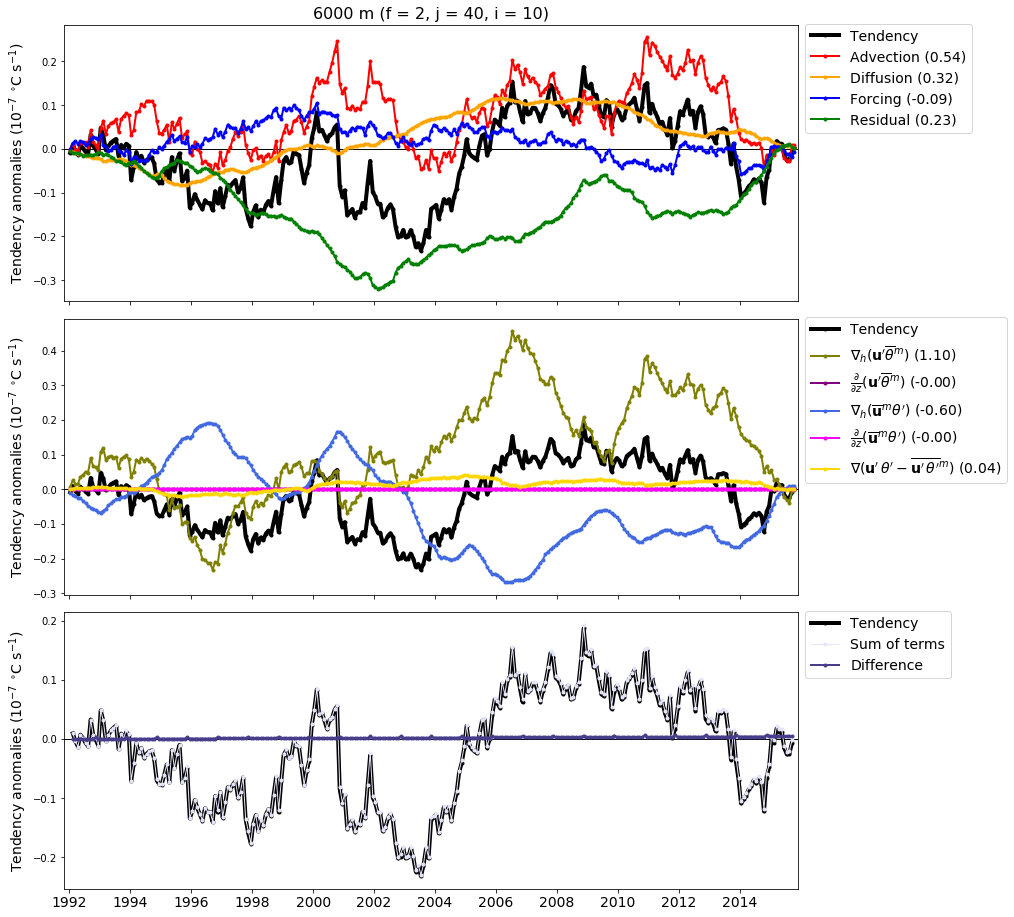

In [20]:
fig, axes = plt.subplots(2, 1,figsize=(17,15))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.title('%s m (f = %s, j = %s, i = %s)' % (D,f,j,i), fontsize=16)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(adv.time, adv, lw=2, color='red', marker='.',label=varstrngs[10] + ' (%.2f)' % corr[9])
plt.plot(results[5].time, results[5], lw=2, color='orange', marker='.',label=varstrngs[11] + ' (%.2f)' % corr[4])
plt.plot(results[6].time, results[6], lw=2, color='blue', marker='.',label=varstrngs[12] + ' (%.2f)' % corr[5])
plt.plot(results[8].time, results[8], lw=2, color='green', marker='.',label=varstrngs[8] + ' (%.2f)' % corr[7])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
#plt.ylim([-1.9e-7,1.3e-7])
#plt.yticks(np.arange(-1.5e-7,1.5e-7,0.5e-7),fontsize=14)
#plt.setp(plt.gca(), 'yticklabels',np.arange(-1.5,1.5,0.5))
plt.ylabel(r'Tendency anomalies (10$^{-7}$ $^{\circ}$C s$^{-1}$)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(results[1].time, results[1], lw=2, color='olive',marker='.',label=varstrngs[1] + ' (%.2f)' % corr[0])
plt.plot(results[2].time, results[2], lw=2, color='purple', marker='.',label=varstrngs[2] + ' (%.2f)' % corr[1])
plt.plot(results[3].time, results[3], lw=2, color='royalblue', marker='.',label=varstrngs[3] + ' (%.2f)' % corr[2])
plt.plot(results[4].time, results[4], lw=2, color='magenta', marker='.',label=varstrngs[4] + ' (%.2f)' % corr[3])
plt.plot(results[7].time, results[7], lw=2, color='gold', marker='.',label=varstrngs[7] + ' (%.2f)' % corr[6])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
#plt.ylim([-2.9e-7,2.1e-7])
#plt.yticks(np.arange(-2.5e-7,2.5e-7,0.5e-7),fontsize=14)
#plt.setp(plt.gca(), 'yticklabels',np.arange(-2.5,2.5,0.5))
plt.ylabel(r'Tendency anomalies (10$^{-7}$ $^{\circ}$C s$^{-1}$)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 3)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time[1:-1], results[0][1:-1], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(total.time[1:-1], total[1:-1], lw=1, color='lavender', marker='.',label='Sum of terms')
plt.plot(results[0].time[1:-1], total[1:-1]-results[0][1:-1], lw=2, 
         color='darkslateblue', marker='.',label='Difference')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
#plt.ylim([-1.9e-7,1.3e-7])
#plt.yticks(np.arange(-1.5e-7,1.5e-7,0.5e-7),fontsize=14)
#plt.setp(plt.gca(), 'yticklabels',np.arange(-1.5,1.5,0.5))
plt.ylabel(r'Tendency anomalies (10$^{-7}$ $^{\circ}$C s$^{-1}$)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/tmp/figure.png')
plt.show()

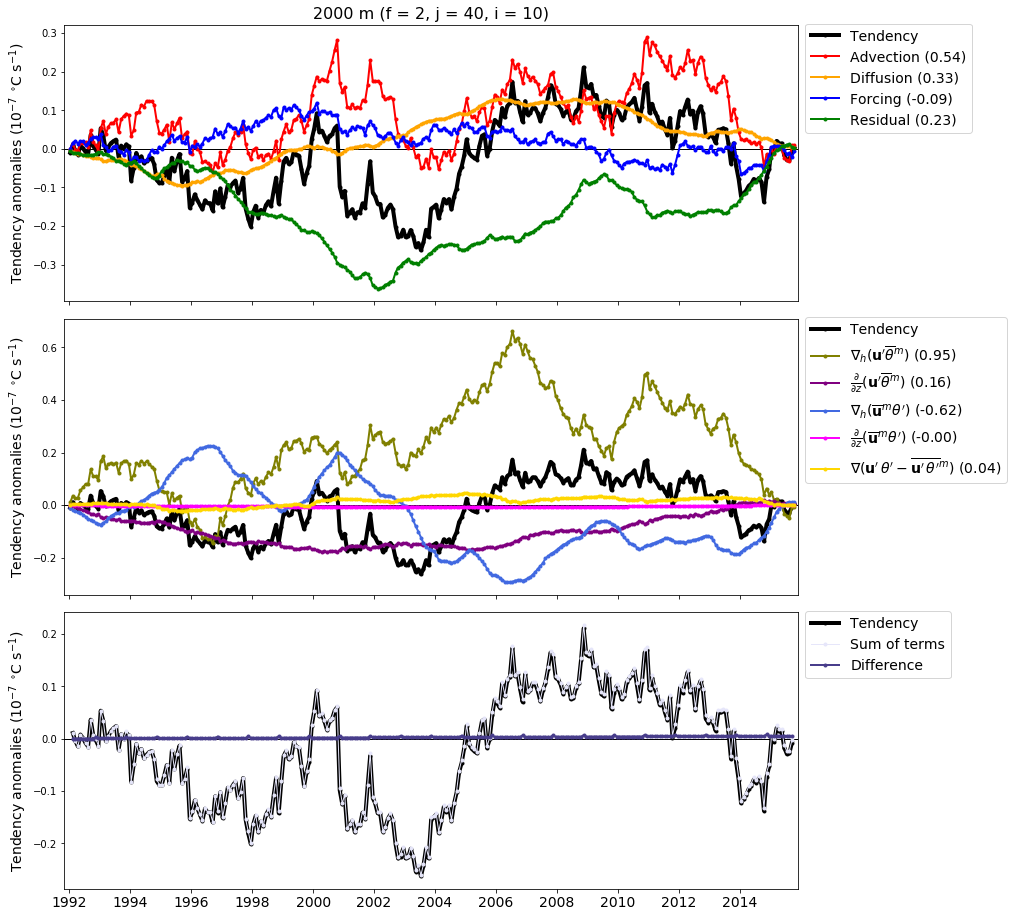

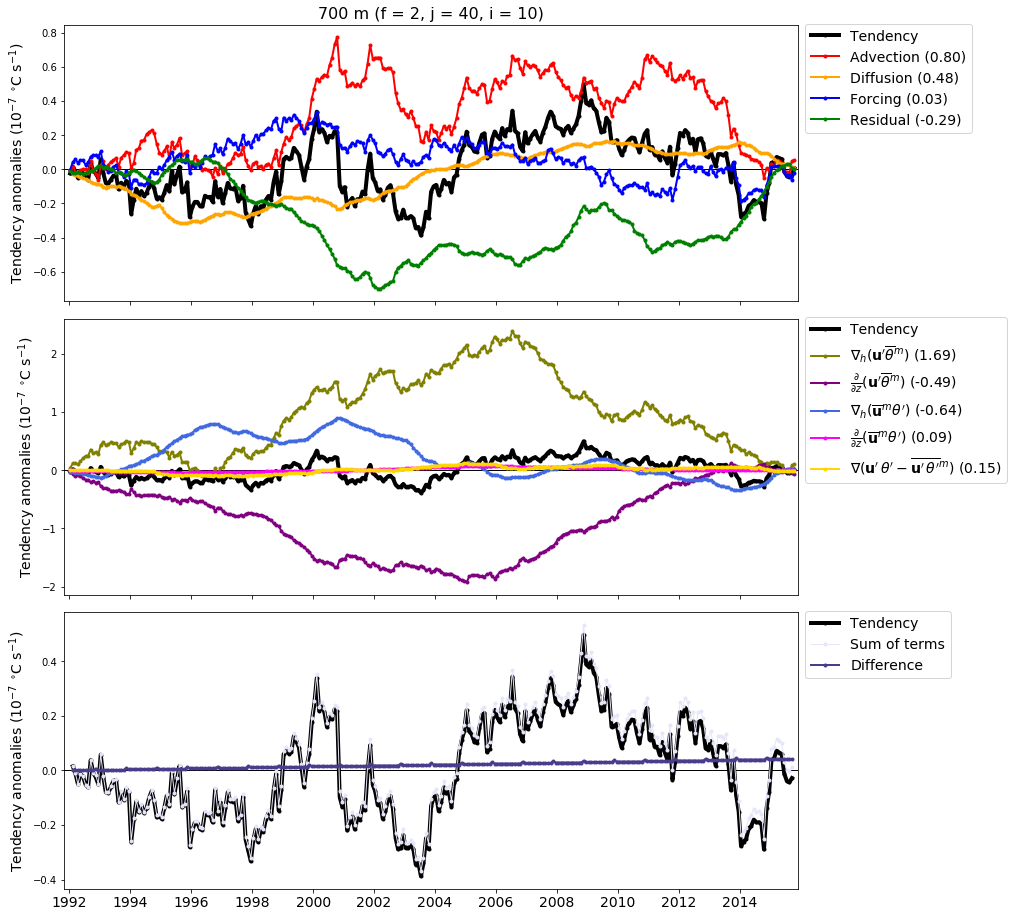

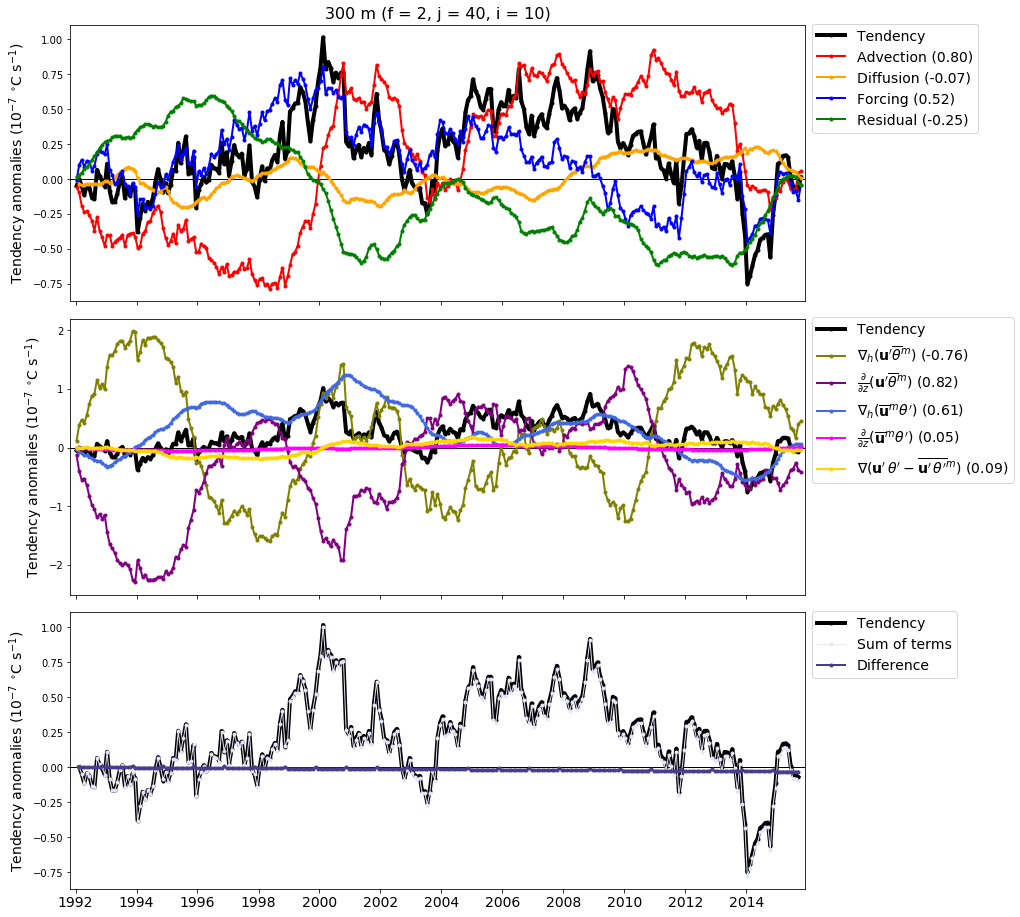